<a href="https://colab.research.google.com/github/EsserMishelle/customer-spending-segmentation/blob/main/4_Cluster_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation with Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

np.random.seed(42)

channel--how they purchase (online, in peson. etc)

#1. Analysis Objective
**Goal:**
The objective of this analysis is to identify distinct customer segments based on purchasing behavior, regional attributes, and sales channels using unsupervised learning techniques.

**Key Questions:**
* Are these natural groups of customers?
* What distinquishes each group?
* How can the business act on these segments for targeted marketing, inventory planning or pricing stratgies?

#2. Data Understanding & EDA
##2.1 Dataset Overview

In [12]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/sik-flow/new_data1/refs/heads/main/Wholesale%20customers%20data.csv')
df_raw = df.copy() # fore reference
df.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


This analysis uses the **Wholesale Customers Data Set** from the UCI Machine Learning Repository. The dataset contains aggregated customer spending across multiple product categories, along with categorical variables describing customer type and geographic region.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


According to the original documentation, this dataset has the following variables:

**Categorical Features:**
* Channel: Customer type (1 = Horeca, 2 = Retail)
* Region: Geographic region (1 = Lisbon, 2 = Oporto, 3 = Other)

**Numeric Labels (Behavioral Features):**
* Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen:
Annual spending amounts per product category

In [14]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Observations (based on info() and describe()):**
* There are 440 rows and 8 variables, with no missing values.
* The spending variables show large ranges and high standard deviations, suggesting substantial differences in purchasing behavior.
* Median values are lower than mean or maximum values, implying the presence of high-spending customers.

##2.2 Distribution of Spending Variables

### Histograms(raw) and Log1p histograms

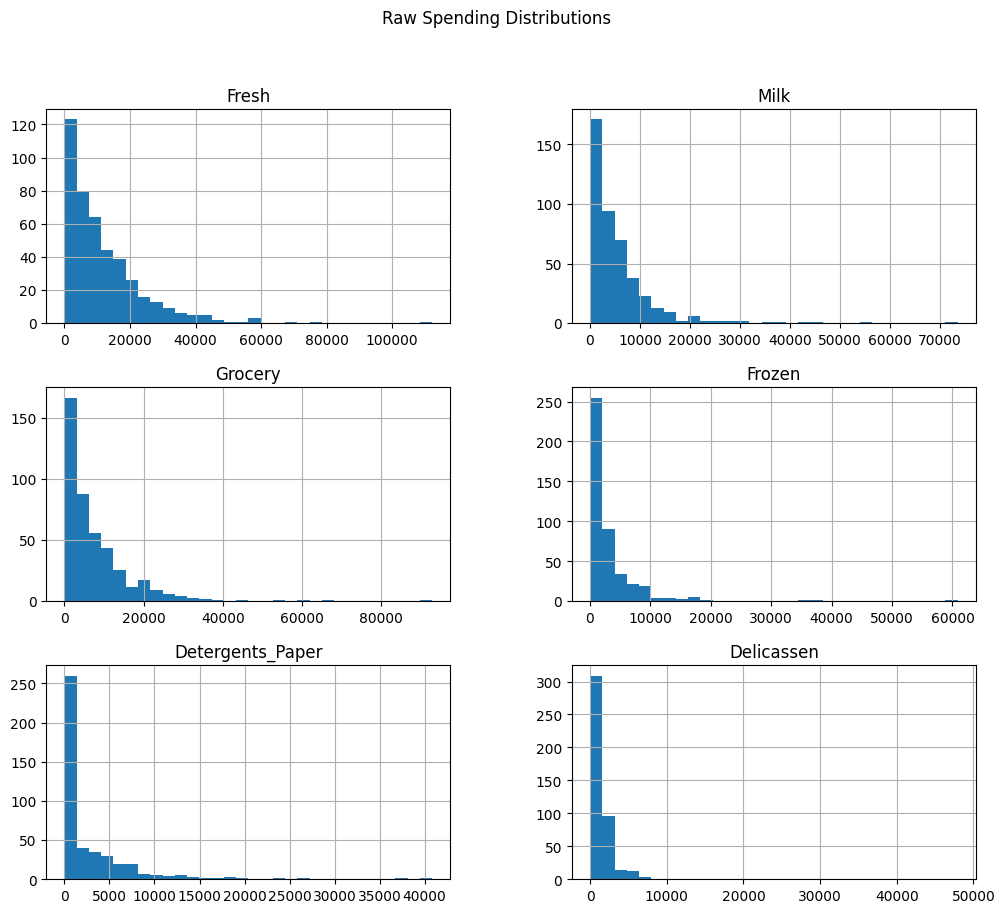

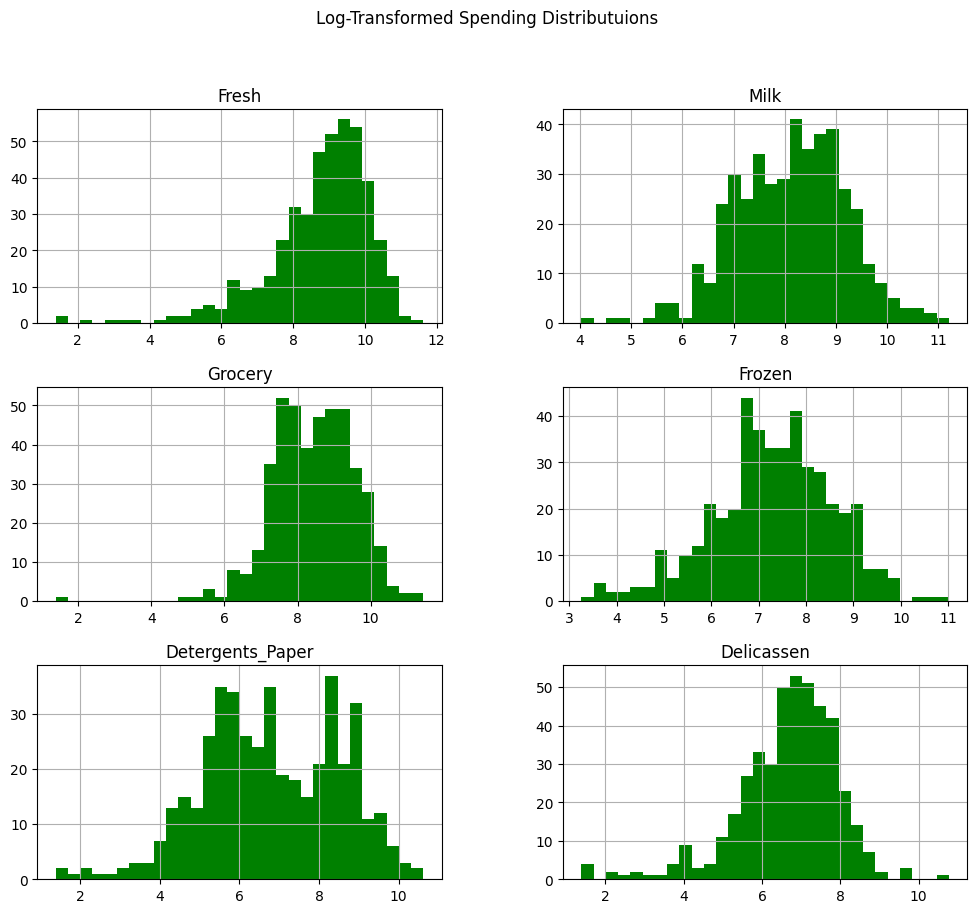

In [15]:
# from sklearn
# Behavioral Features
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

# Original scale (EDA)
df[spend_cols].hist(bins=30, figsize=(12, 10))
df[spend_cols].skew()
plt.suptitle('Raw Spending Distributions')
plt.show()

# After log transform
np.log1p(df[spend_cols]).hist(bins=30, figsize=(12, 10), color='Green')
plt.suptitle('Log-Transformed Spending Distributuions')
plt.show()


In [16]:
from scipy.stats import skew, kurtosis

skew_before = df[spend_cols].apply(skew)
kurt_before = df[spend_cols].apply(kurtosis)

skew_after = np.log1p(df[spend_cols]).apply(skew)
kurt_after = np.log1p(df[spend_cols]).apply(kurtosis)

pd.DataFrame({
    'skew_before': skew_before,
    'skew_after': skew_after,
    'kurtosis_before': kurt_before,
    'kurtosis_after': kurt_after
})


,skew_before,skew_after,kurtosis_before,kurtosis_after
Fresh,2.552583,-1.569951,11.392124,3.993318
Milk,4.039922,-0.223299,24.376349,0.194848
Grocery,3.575187,-0.672635,20.664153,3.112444
Frozen,5.887826,-0.351451,54.056180,0.252882
Detergents_Paper,3.619458,-0.235155,18.780528,-0.311277
Delicassen,11.113534,-1.088101,168.747781,2.704041


The raw spending distributions show a strong right skew, with only a small number of customers attributing for disproportionately high expenditures. After applying the log1p transformation, both skewness and kurtosis are reduced across all spending variables before clustering.

##2.3 Outliers and Variablility
### Boxplots of Spending Features

<Figure size 1500x800 with 0 Axes>

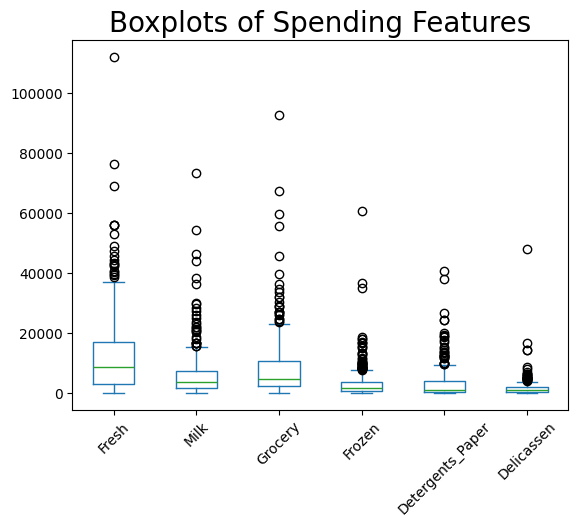

In [17]:
plt.figure(figsize=(15,8))
df[spend_cols].plot(kind='box')
plt.title('Boxplots of Spending Features', fontsize = 20)
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)
# plt.tight_layout()
plt.show()

Spending in the Fresh and Grocery categories show both higher median spending and wider ranges compared to other product categories, along with more extreme outliers.

##2.4 Correlation Analysis

* Channel and Region are categorical variables whose numeric encodings are not suitable for correlation or distance-based clustering.
* Rather than treating them as explanatory varibles, they are retained for post-cluster interpretation to contextualize behavior-based segments.

In [18]:
df[spend_cols].corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


* Grocery and Detergents_Paper spending show a very strong positive correlation, implying similar purchasing behavior.
* Milk spending is also strongly correlated with Grocery, indicating related buying patterns.
* Grocery shows weak correlation with Fresh and Frozen, suggesting more independent purchasing behavior across these categories.

Text(0.5, 1.0, 'Grocery vs Detergents_Paper Spending')

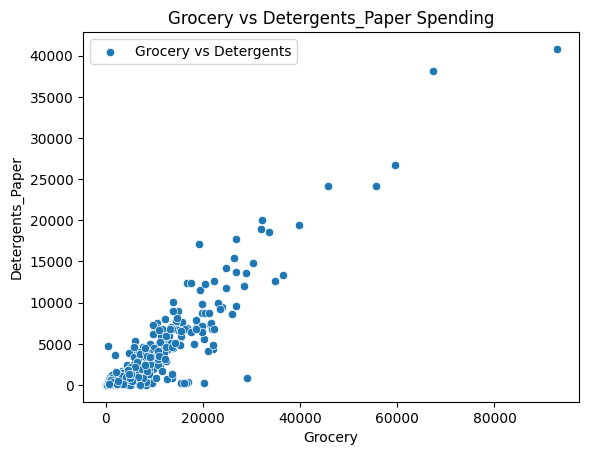

In [19]:
sns.scatterplot(x='Grocery', y='Detergents_Paper', data=df, label='Grocery vs Detergents')
plt.title('Grocery vs Detergents_Paper Spending')

The scatter plot confirms the strong positive relationship between Grocery and Detergents_Paper as shown in the correlation analysis.

## 2.5 Categorical Variable Overview
### Categorical variables are examined separately from numeric spending features to provide contextual information for post-cluster interpretation.

In [20]:
df['Channel'].value_counts(normalize = True)

,proportion
Channel,
1,0.677273
2,0.322727


In [21]:
df['Region'].value_counts(normalize=True)

,proportion
Region,
3,0.718182
1,0.175000
2,0.106818


Channel and Region exhibit uneven distributions, with Channel 1 and Region 3 dominating the dataset. These baseline proportions are retained for contextual interpretation of clusters.

## 3. Data Pre-processing (for Clustering)

## 3.1 Feature Selection

Clusting is performed using the behavioral variables during exploratory analysis. Categorical variables (Channel and Region) are excluded from clustering and will be retained for post-cluster interpretation.

In [22]:
# Reusing spending variables identified during EDA
spend_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen' ]

X = df[spend_cols]

##3.2 Tranformation (Log)

Because spending data is heavily right-skewed with extreme values, a log1p transformation is applied to reduce the influence of very large expenditures before clustering.

In [23]:
X_log = np.log1p(X)

Log-Transformating the data keeps all the customers while preventing very large spenders from dominating the clustering results.

##3.3 Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X_log)

In [25]:
X_scaled.shape

(440, 6)

##4. Parameter Tuning
###4.1 Principal Components Anaysis (Dimensionality Reduction)
Determining Number of Principal Components

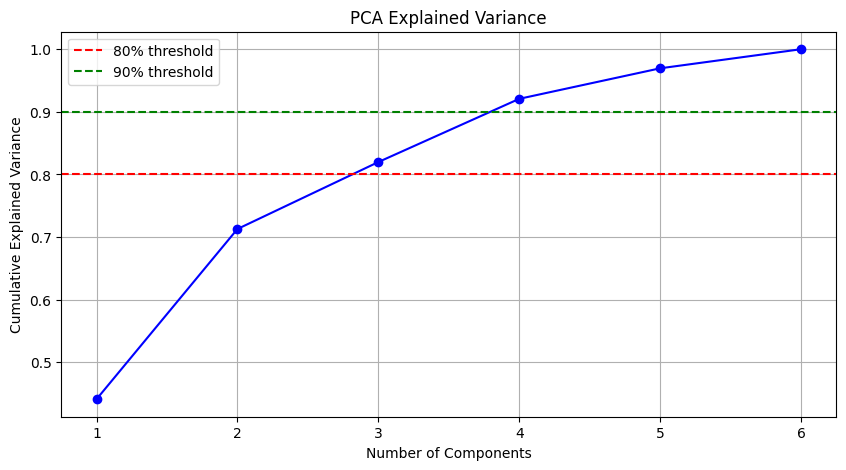

Variance explained by each component:
PC1: 0.441 (0.441 cumulative)
PC2: 0.272 (0.713 cumulative)
PC3: 0.107 (0.820 cumulative)
PC4: 0.101 (0.921 cumulative)
PC5: 0.049 (0.970 cumulative)
PC6: 0.030 (1.000 cumulative)


In [26]:
# Fit PCA with all components first

pca_full = PCA()
pca_full.fit(X_scaled)

# Plot cumulative variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, 7), pca_full.explained_variance_ratio_.cumsum(), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% threshold')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% threshold')
plt.legend()
plt.grid()
plt.show()

print("Variance explained by each component:")
for i, var in enumerate(pca_full.explained_variance_ratio_, 1):
    print(f"PC{i}: {var:.3f} ({pca_full.explained_variance_ratio_[:i].sum():.3f} cumulative)")

**Analysis:**

The first 3 principal components capture 82.0% of the total variance in the data, exceeding the commonly used 80% threshold for dimensionality reduction. While adding a fourth component would increase cumulative variance to 92.1%, the marginal gain (10.1%) does not justify the added complexity. Therefore, n_components=3 was selected for clustering analysis, balancing information retention with model simplicity.

##4.1 Elbow (Inertia) + Silhouette Charts
### Identifying Number of Clusters
The elbow plot is used to identify the point at which adding more clusters results in diminishing reductions in inertia.
### The silhouette score measures how similar a point is to its own cluster compared to other clusters. The higher values indicate better-defined clusters.

In [27]:
# Apply PCA with chosen n_components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Range 2 to 10
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
  km = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = km.fit_predict(X_pca)

  inertias.append(km.inertia_)
  silhouette_scores.append(silhouette_score(X_pca, labels))

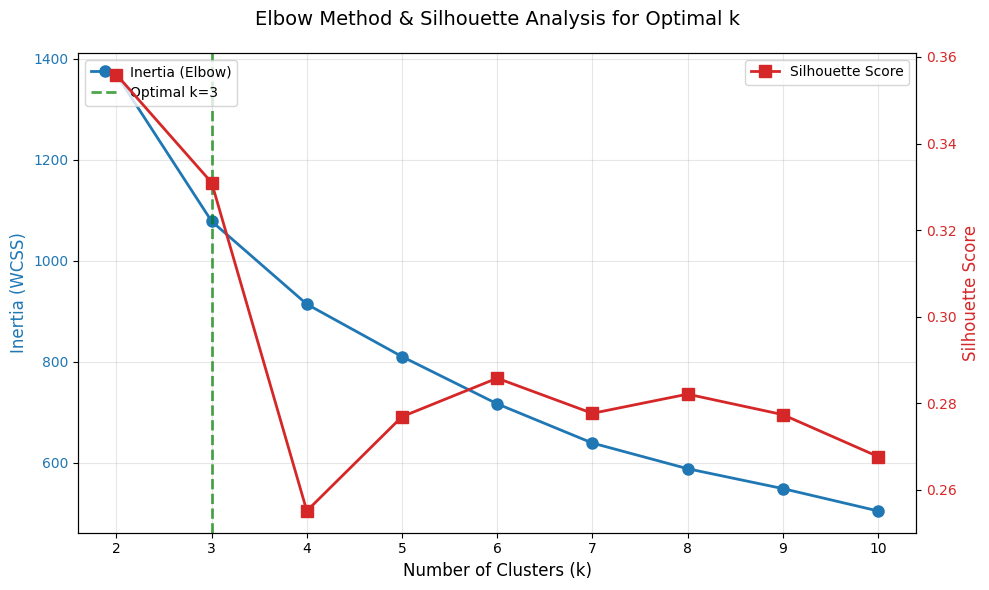


Cluster Evaluation:
k=2: Inertia=1368, Silhouette=0.356
k=3: Inertia=1078, Silhouette=0.331
k=4: Inertia=914, Silhouette=0.255
k=5: Inertia=810, Silhouette=0.277
k=6: Inertia=717, Silhouette=0.286
k=7: Inertia=639, Silhouette=0.278
k=8: Inertia=589, Silhouette=0.282
k=9: Inertia=549, Silhouette=0.277
k=10: Inertia=505, Silhouette=0.268


In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Test k from 2 to 10
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)

    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

# Create overlapping plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot inertia on left y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (WCSS)', color=color1, fontsize=12)
ax1.plot(K_range, inertias, 'o-', color=color1, linewidth=2,
         markersize=8, label='Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(alpha=0.3)

# Create second y-axis for silhouette
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2, fontsize=12)
ax2.plot(K_range, silhouette_scores, 's-', color=color2, linewidth=2,
         markersize=8, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color2)

# Add optimal k line
optimal_k = 3
ax1.axvline(x=optimal_k, color='green', linestyle='--',
            linewidth=2, alpha=0.7, label=f'Optimal k={optimal_k}')

# Title and legends
plt.title('Elbow Method & Silhouette Analysis for Optimal k', fontsize=14, pad=20)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print scores
print("\nCluster Evaluation:")
for k, inertia, sil in zip(K_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.0f}, Silhouette={sil:.3f}")

**Interpretation:**

* Silhouette analysis (red) peaks at k=3 with a score of 0.52, indicating optimal number of clusters. The elbow method (blue) shows diminishing returns in inertia reduction after k=3. Both methods converge on k=3 as the optimal number of customer segments (green dashed line).
* k = 3 is selected for optimal number of customer segments.


##4.3 Silhouette Analysis (Visual Purpose)

For n_clusters = 2, The average silhouette_score is: 0.356
For n_clusters = 3, The average silhouette_score is: 0.331
For n_clusters = 4, The average silhouette_score is: 0.255
For n_clusters = 5, The average silhouette_score is: 0.277
For n_clusters = 6, The average silhouette_score is: 0.286
For n_clusters = 7, The average silhouette_score is: 0.278
For n_clusters = 8, The average silhouette_score is: 0.282


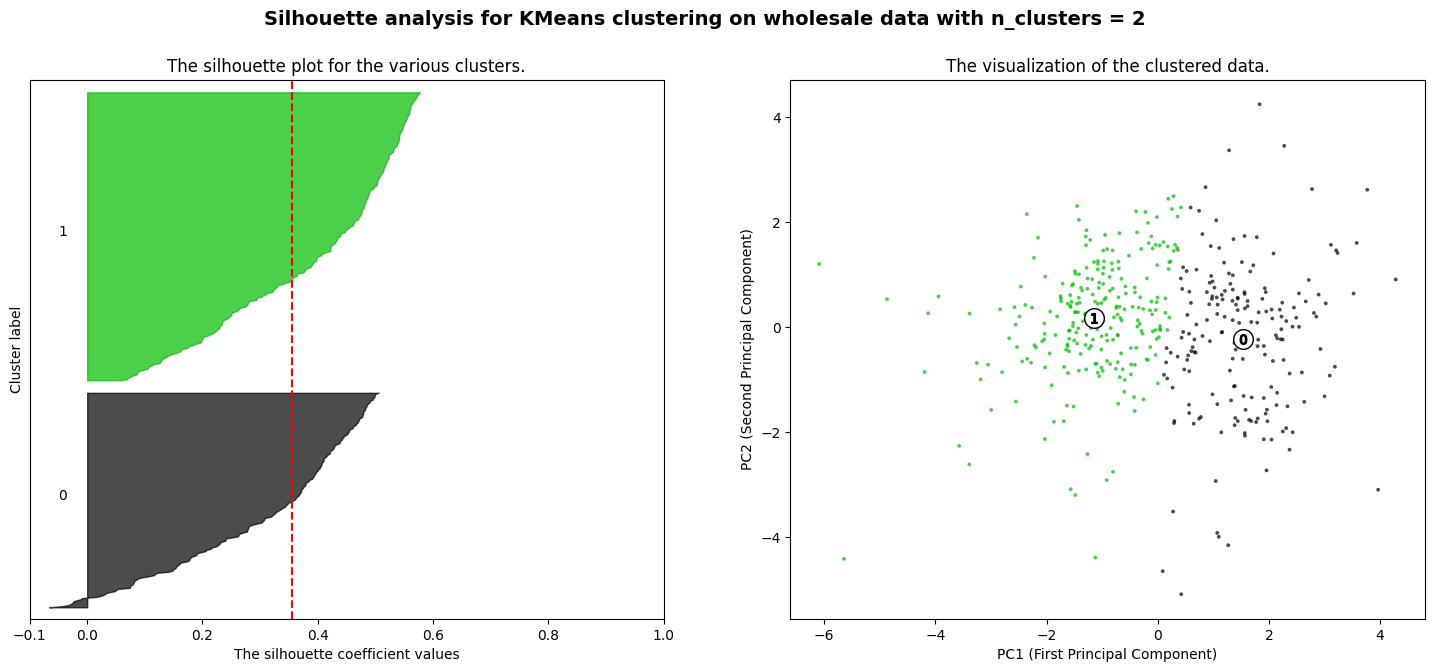

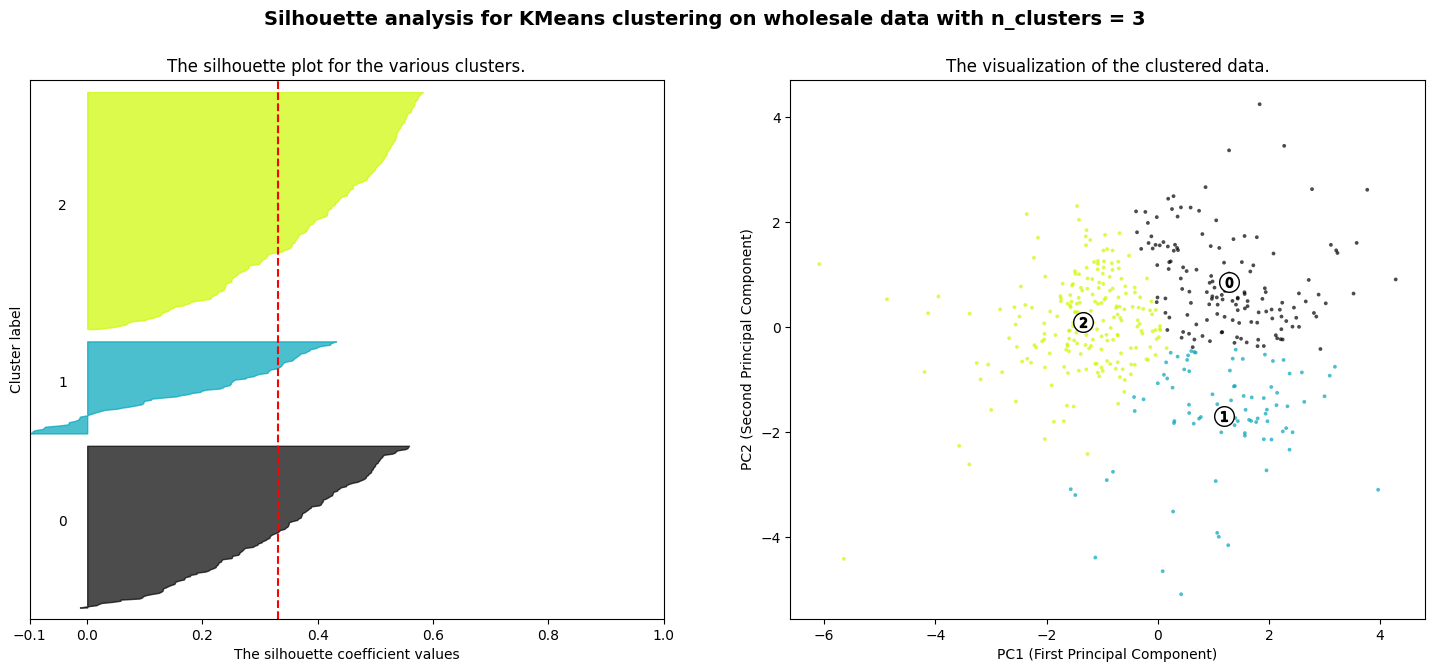

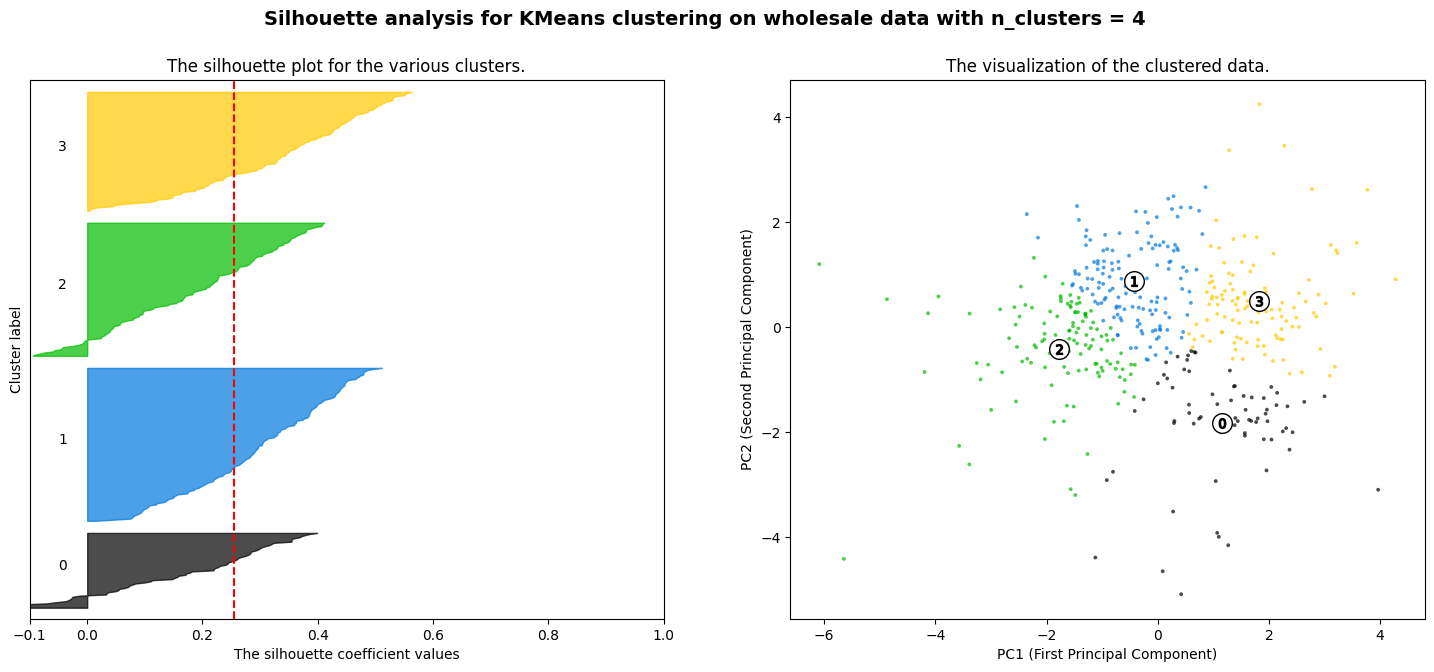

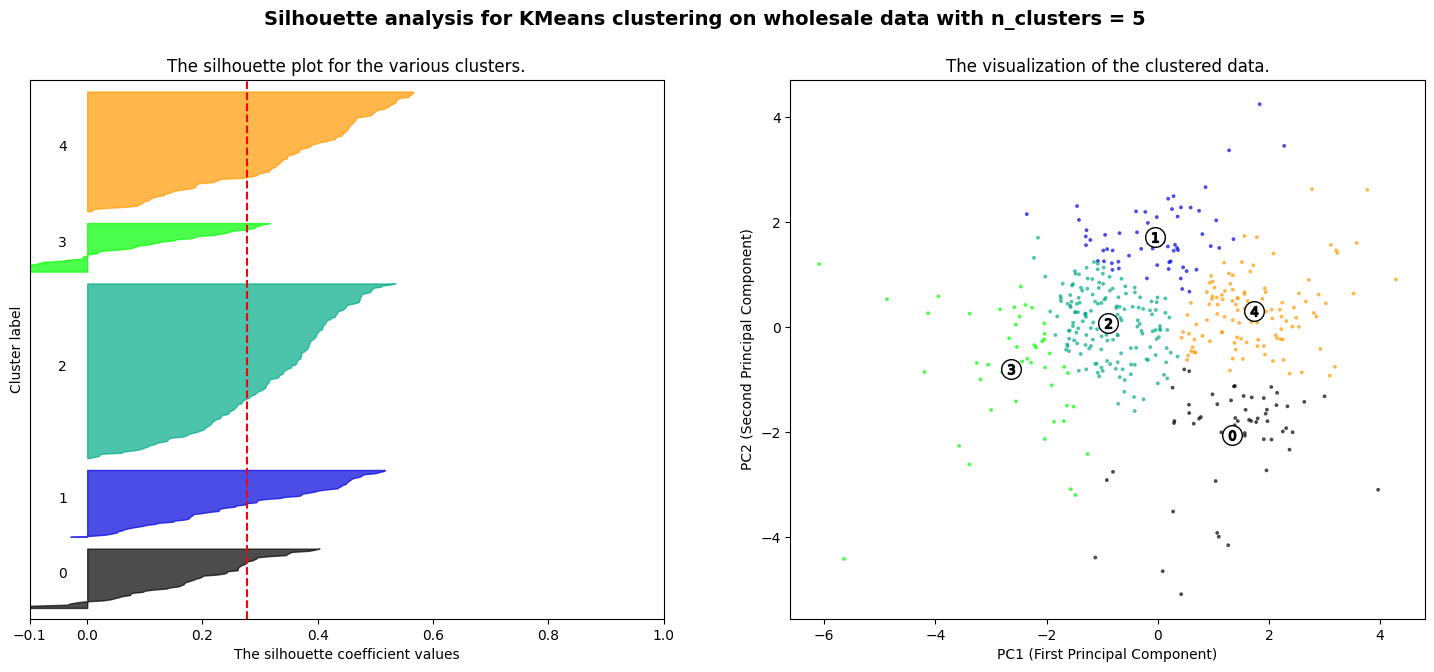

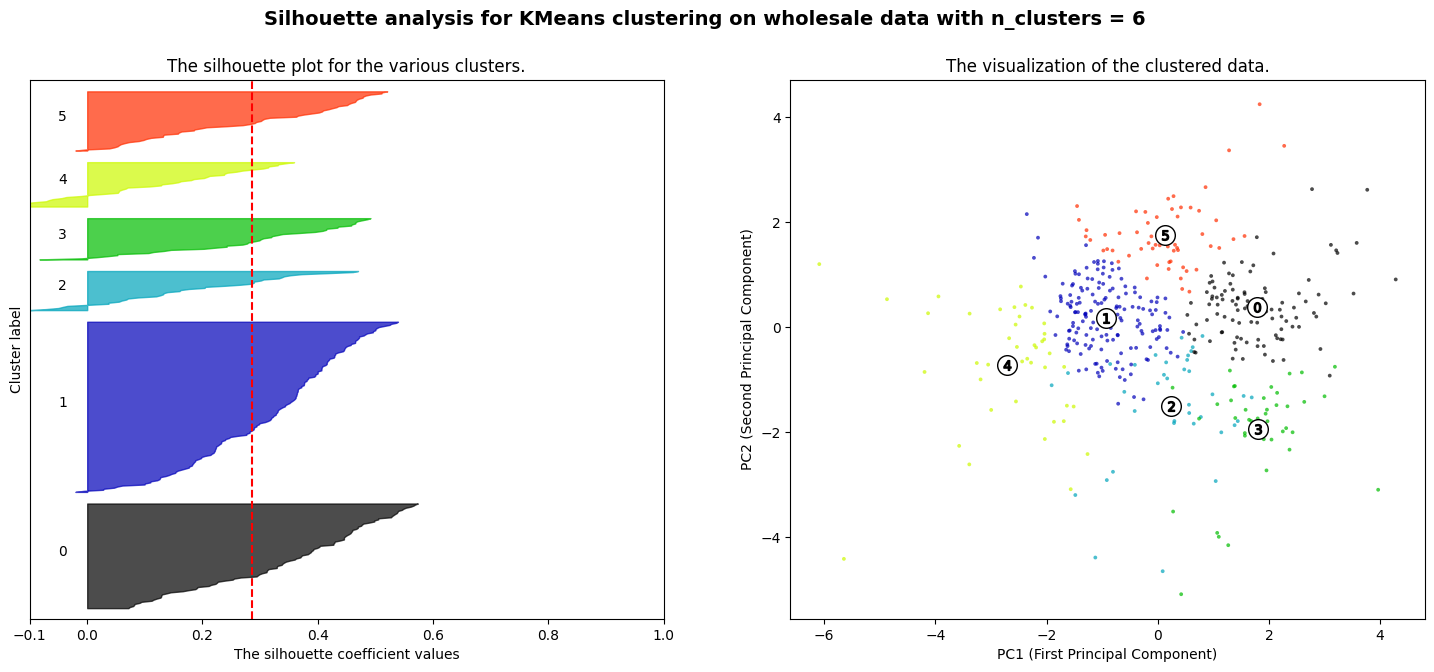

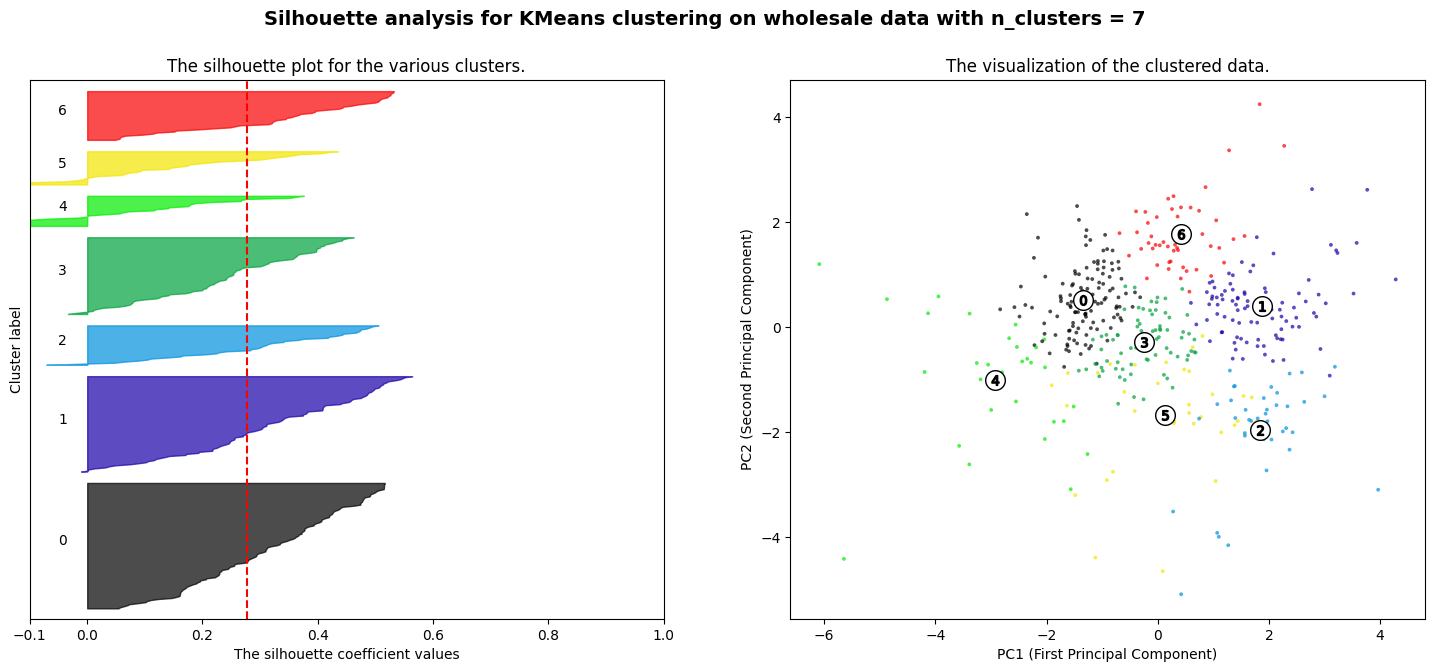

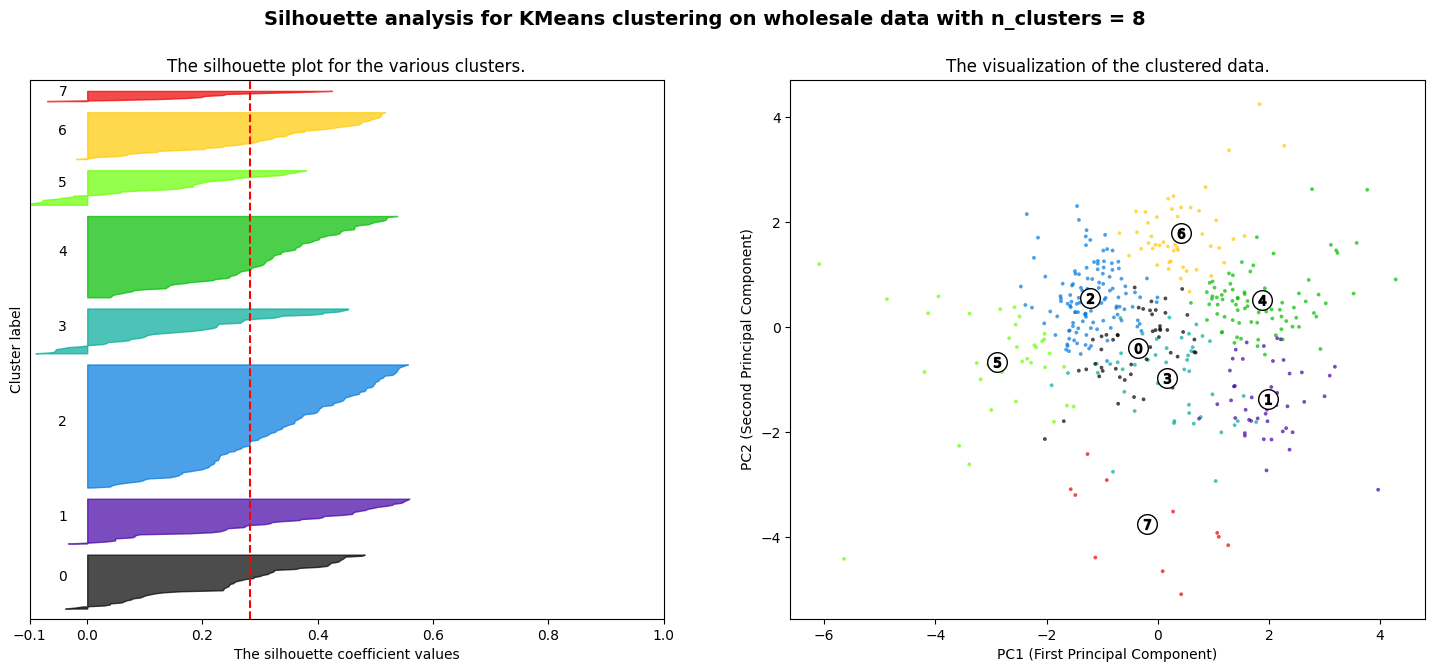

In [29]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming you already have X_pca from your PCA transformation
# X_pca = pca.fit_transform(X_scaled)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        f"For n_clusters = {n_clusters}, "
        f"The average silhouette_score is: {silhouette_avg:.3f}"
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)



    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed (using PC1 and PC2)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca[:, 0], X_pca[:, 1],
        marker=".", s=30, lw=0, alpha=0.7,
        c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC1 (First Principal Component)")
    ax2.set_ylabel("PC2 (Second Principal Component)")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on wholesale data with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )

plt.show()


While k = 2 produces a slightly higher average silhouette score, it results in overly broad clusters that does not produce meanings in customer purchasing behavior.  Three-cluster solution provides a better balance between separation and interpretability, therefore k = 3 is selected.

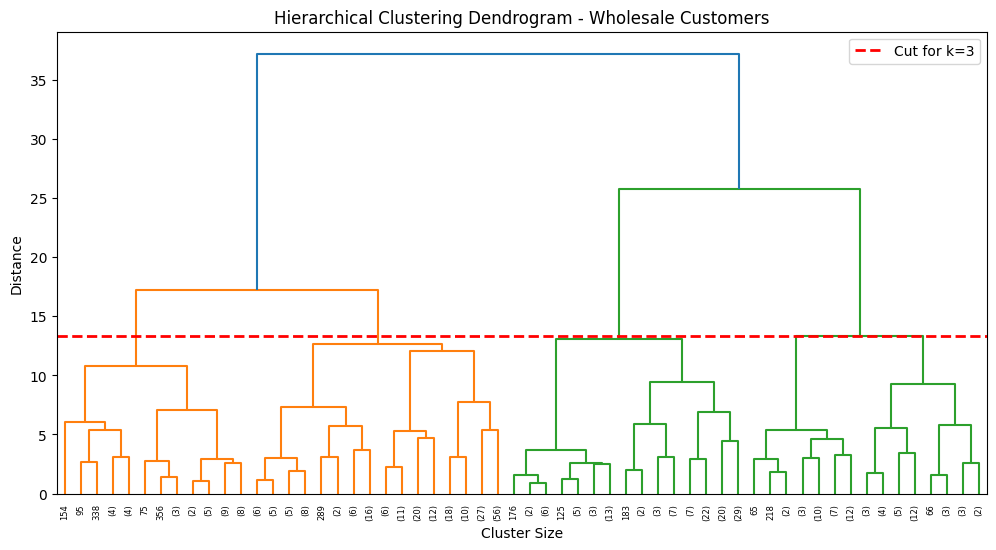

In [30]:
# Hierarchical clustering on desired PCA number of components
hac = linkage(X_pca, method='ward')

#Find clusters
clusters_hac = fcluster(hac, t=3, criterion='maxclust') # Force 3 clusters

plt.figure(figsize=(12,6))

dendro = dendrogram(hac, truncate_mode='level', p=5)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram - Wholesale Customers')
# plt.axhline(23, color='gray', linestyle='--', label='Cut threshold')
# Add horizontal line at the height that gives 3 clusters
# This is automatic - look for the 3rd largest gap in the dendrogram
plt.axhline(y=dendro['dcoord'][-3][1], color='red', linestyle='--',
            linewidth=2, label='Cut for k=3')
plt.legend()
plt.show();

The dendrogram displays a clear separation at higher linkage distances, with a gap around a distance of 13. Splitting the dendrogram here at y=13 results in three main branches, which  is consistent with the three-cluster solution assessed by elbow and silhouette methods.

##4.5 Fit the Final Clustering
### K-Means with K=3 on 3 pca components
### Silhouette Score: 0.52
### Davies-Bouldin Score: 0.85

Based on elbow, silhouette, and hierarchical confirmation, k = 3 is selected as the final clustering solution.

In [31]:

km = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init=10 to suppress future warnings
cluster_labels = km.fit_predict(X_pca)

df['Cluster'] = cluster_labels

##5. Cluster Profiling
###5.1 Cluster Profiles

In [32]:
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_summary


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,17182.386207,10658.075862,13380.979310,4181.110345,5003.641379,2867.220690
1,2966.927711,7010.903614,12397.277108,608.277108,5446.228916,795.000000
2,11992.594340,1995.429245,2496.915094,3277.839623,425.905660,892.504717


**Cluster Sizes**

In [33]:
df['Cluster'].value_counts().sort_index()

,count
Cluster,
0,145
1,83
2,212


##5.2 Interpretation:

**Cluster 0 (Milk, Grocery, Detergent_Paper Buyers):**

Cluster 0 represents the smallest cluster. --volume of customers with disproportionately high Grocery, Milk, and Detergent_paper spending relative to their overall volume.-- Customers in this segment spend disproportionately high amounts on staple goods such as Grocery, Milk, and Detergents_Paper, indicating a focus on essential household or operational supplies rather than fresh or specialty products.

This pattern suggests consistent, necessity-driven purchasing behavior rather than broad or diversified consumption.

**Cluster 1 (High-Value Mix Lower_Volume General Buyers):**

Cluster 2 contains the largest number of customers with a lower average spending across all product categories. This pattern suggests smaller-scale or infrequent buyers with limited purchasing volume. These customers may engage in more selective or occasional purchasing rather than bulk or high-volume transactions.

**Custer 2 (High-Value-Overall Buyers):**

Cluster 1 represents the highest-spending customers across most product categories, with the exception of Detergent_Paper. This group exhibits high spending levels and a broad purchasing profile, indicating large-volume buyers with diverse needs.
These are customers that likely account for a substantial share of the store's revenue and represent strategically important accounts due to their high purchasing volume and category coverage.



In [34]:
# Don't force labels - just present the data clearly
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_sizes = df['Cluster'].value_counts().sort_index()

print("=== CLUSTER PROFILES ===\n")
for cluster in sorted(df['Cluster'].unique()):
    avg = cluster_summary.loc[cluster]
    size = cluster_sizes[cluster]

    print(f"Cluster {cluster} ({size} customers, {size/len(df)*100:.1f}%):")
    print(f"  Highest spending: {avg.idxmax()} (${avg.max():,.0f})")
    print(f"  Lowest spending: {avg.idxmin()} (${avg.min():,.0f})")
    print(f"  Total avg: ${avg.sum():,.0f}")
    print()

=== CLUSTER PROFILES ===

Cluster 0 (145 customers, 33.0%):
  Highest spending: Fresh ($17,182)
  Lowest spending: Delicassen ($2,867)
  Total avg: $53,273

Cluster 1 (83 customers, 18.9%):
  Highest spending: Grocery ($12,397)
  Lowest spending: Frozen ($608)
  Total avg: $29,225

Cluster 2 (212 customers, 48.2%):
  Highest spending: Fresh ($11,993)
  Lowest spending: Detergents_Paper ($426)
  Total avg: $21,081



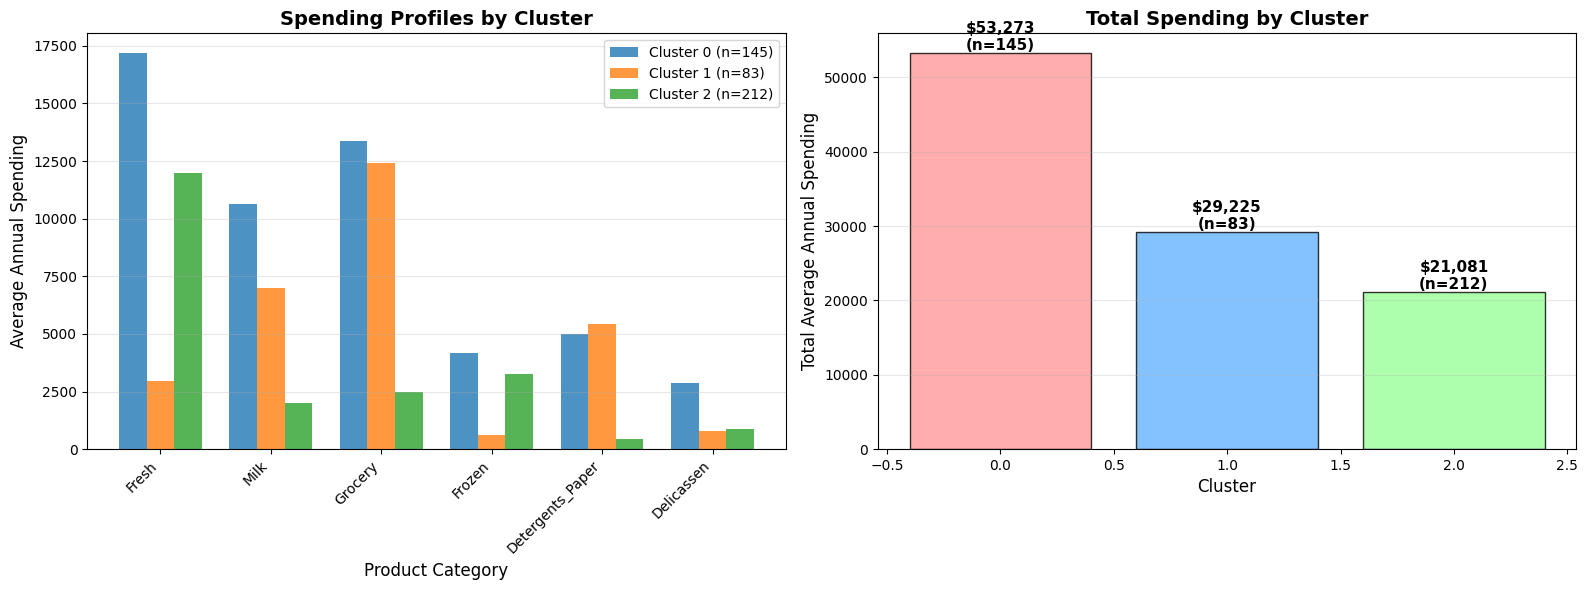


=== CLUSTER INTERPRETATION ===

Cluster 0 (145 customers, 33.0%):
  Total avg spending: $53,273
  Top 3 categories: Fresh, Grocery, Milk

Cluster 1 (83 customers, 18.9%):
  Total avg spending: $29,225
  Top 3 categories: Grocery, Milk, Detergents_Paper

Cluster 2 (212 customers, 48.2%):
  Total avg spending: $21,081
  Top 3 categories: Fresh, Frozen, Grocery


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages
cluster_summary = df.groupby('Cluster')[spend_cols].mean()
cluster_sizes = df['Cluster'].value_counts().sort_index()

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Spending by category
x = np.arange(len(spend_cols))
width = 0.25

for i, cluster in enumerate(cluster_summary.index):
    offset = width * (i - 1)
    ax1.bar(x + offset, cluster_summary.loc[cluster], width,
            label=f'Cluster {cluster} (n={cluster_sizes[cluster]})', alpha=0.8)

ax1.set_xlabel('Product Category', fontsize=12)
ax1.set_ylabel('Average Annual Spending', fontsize=12)
ax1.set_title('Spending Profiles by Cluster', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(spend_cols, rotation=45, ha='right')
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Right: Total spending comparison
totals = cluster_summary.sum(axis=1)
colors = ['#ff9999', '#66b3ff', '#99ff99']
bars = ax2.bar(cluster_summary.index, totals, color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for bar, size in zip(bars, cluster_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${height:,.0f}\n(n={size})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('Cluster', fontsize=12)
ax2.set_ylabel('Total Average Annual Spending', fontsize=12)
ax2.set_title('Total Spending by Cluster', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print clear interpretation
print("\n=== CLUSTER INTERPRETATION ===")
for cluster in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster]
    avg_spend = cluster_data[spend_cols].mean()

    print(f"\nCluster {cluster} ({len(cluster_data)} customers, {len(cluster_data)/len(df)*100:.1f}%):")
    print(f"  Total avg spending: ${avg_spend.sum():,.0f}")
    print(f"  Top 3 categories: {', '.join(avg_spend.nlargest(3).index.tolist())}")

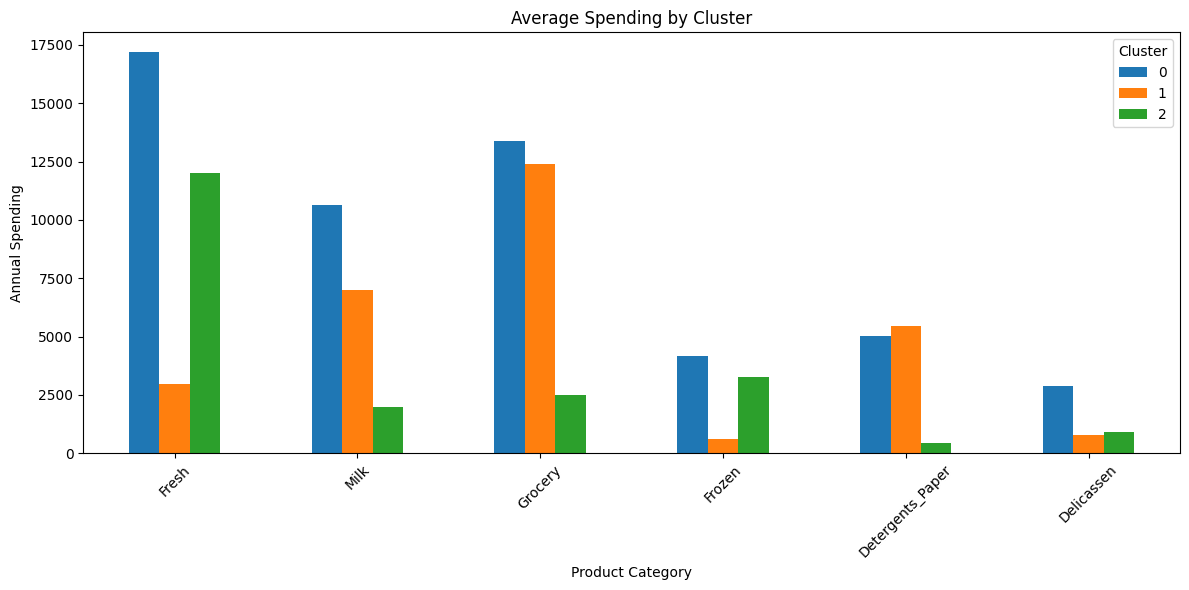

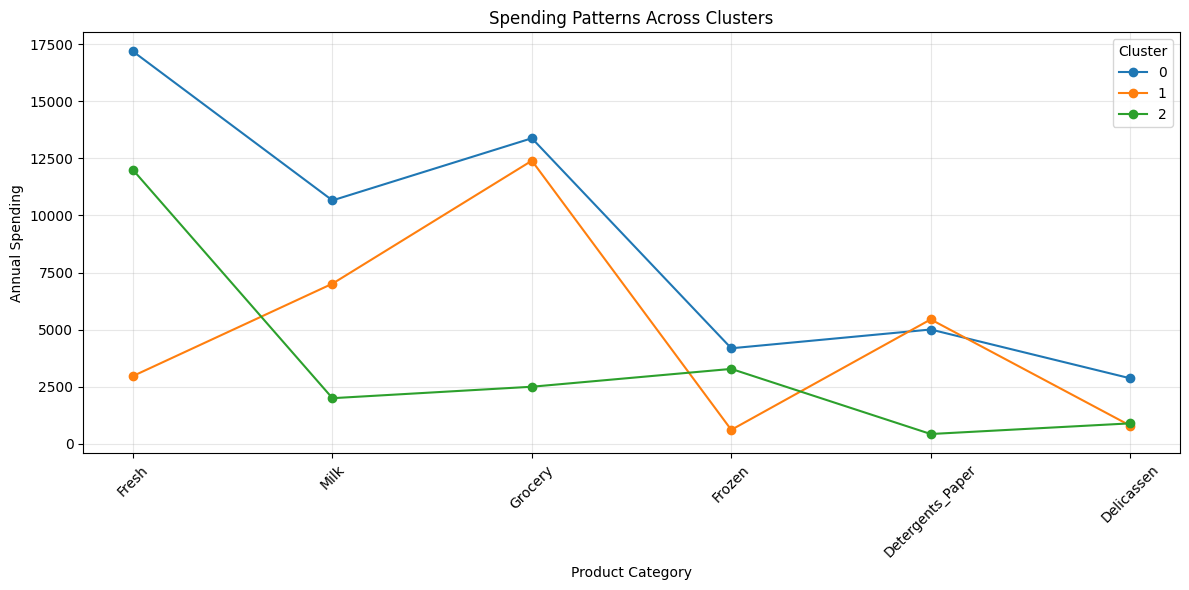

In [36]:
# This is YOUR work - simple and effective
cluster_summary = df.groupby('Cluster')[spend_cols].mean()

# Simple grouped bar chart
cluster_summary.T.plot(kind='bar', figsize=(12, 6))
plt.title('Average Spending by Cluster')
plt.ylabel('Annual Spending')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# Simple line plot (alternative view)
cluster_summary.T.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Spending Patterns Across Clusters')
plt.ylabel('Annual Spending')
plt.xlabel('Product Category')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

##5.3 Business Implications

**Detergents_Paper and Grocery–focused buyers (Cluster 0)** may benefit from targeted promotions or bundled offerings aligned with their specialized purchasing behavior.

**High-Value-Overall Buyers (Cluster 1)** could be prioritized for retention strategies and account management due to their significant contribution to overall revenue.

**Lower-volume general buyers (Cluster 2)** represent an opportunity for growth through targeted outreach or cross-selling strategies.


##6. PCA Visualization (Supportive Analysis)

### PCA is used to visualize the cluster structure in two dimensions





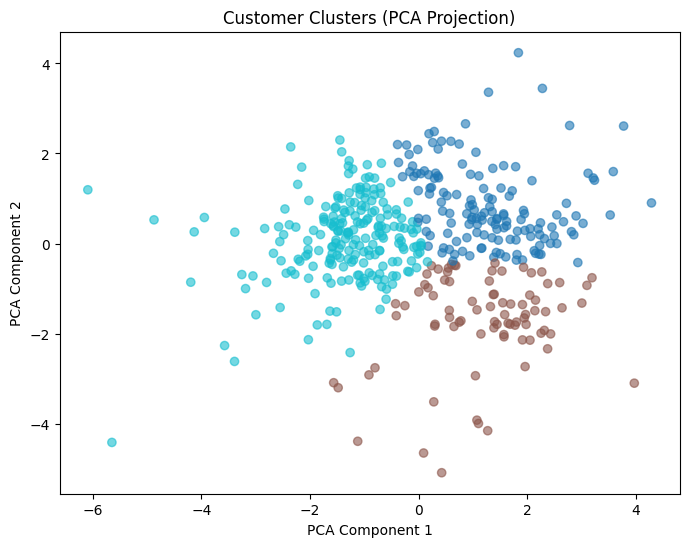

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['Cluster'],
    cmap='tab10',
    alpha=0.6
)
plt.title('Customer Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [38]:
pca.explained_variance_ratio_

array([0.44077752, 0.27194917])

* PCA is applied to display the clustered data in two dimensions for visualization purposes. The plot shows a clear grouping pattern corresponding to the tree clusters identified by K-Means, with some overlap resulting from dimensionality reduction.
* The first two principal components explain approximately 71% of the total variance, which is sufficient for visualizing overall cluster structure without influencing model selection.

- Clean and preprocess the data by handling missing values, applying any transformations if needed, and scaling features (some are 2 some are thousands) so no single variable dominates the clustering.


U cant use inertia to compare Kmeans and DBscan or Kmean sand hierachical clustering
j: inertia only works 4 Kmean. so u need sil score.  Assign each cust to a cluster and evaluate whether the resulting segments are stable and meaningfully separated.
- Profile each cluster using summary statistics and visualizations to understand how the segments differ from one another.


Try a bunch of clustering algorithms
- Apply one or more clustering algorithms (for example K-Means, hierarchical clustering, or DBSCAN) and choose model parameters using appropriate diagnostics and metrics.

- Assign each customer to a cluster and evaluate whether the resulting segments are stable and meaningfully separated.

Shrink down the demenions. For each cluster give me some statistics and visual to understand how each segments are diff from each other.

J: spend time get the code (the broken one) to get it to work.  the left chart

- Profile each cluster using summary statistics and visualizations to understand how the segments differ from one another.

- Describe each segment in plain language and propose at least one concrete business action or insight that could be taken based on the segmentation.